In [6]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
from tensorflow.python.keras import backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input
from sklearn.metrics import confusion_matrix
import gc
from tensorflow.keras.layers import *
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import math
from skimage.transform import resize


loading the data

In [ ]:
import cv2
import glob
import numpy as np

X_data = []
files = glob.glob ("/content/train/mask/*.jpg")
for myFile in files:
    # print(myFile)
    gc.collect()
    image = cv2.imread (myFile)
    image = np.asarray(image)
    X_data.append (image)
X_data=np.asarray(X_data)
print('X_data shape:', X_data.shape)


Y_data = []
files = glob.glob ("/content/train/mask/*.bmp")
for myFile in files:
    # print(myFile)
    gc.collect()
    image = cv2.imread (myFile)
    image = np.asarray(image)
    Y_data.append (image)
Y_data=np.asarray(Y_data)
print('X_data shape:', Y_data.shape)

loading mini data

In [79]:
import cv2
import glob
import numpy as np

X_data = []
files = glob.glob ("/content/drive/MyDrive/dummy/img/*.jpg")
i=0
for myFile in files:
    i+=1
    if i >=15:
      break
    if i %100==0:
      print(i)
    # print(myFile)
    gc.collect()
    image = cv2.imread (myFile)
    image = np.asarray(image)
    X_data.append (image)
X_data=np.asarray(X_data)
print('X_data shape:', X_data.shape)

i=0
Y_data = []
files = glob.glob ("/content/drive/MyDrive/dummy/mask/*.bmp")
for myFile in files:
    i+=1
    if i>=15:
      break
    if i %100==0:
      print(i)
    # print(myFile)
    gc.collect()
    image = cv2.imread (myFile)
    image = np.asarray(image)
    Y_data.append (image)
Y_data=np.asarray(Y_data)
print('Y_data shape:', Y_data.shape)

X_data shape: (15, 340, 512, 3)
Y_data shape: (15, 340, 512, 3)


test train split

In [81]:
xtrain = X_data[:12,:,:,:]
ytrain = Y_data[:12,:,:,:]

xtest = X_data[-3:,:,:,:]
ytest = Y_data[-3:,:,:,:]

functions

In [83]:
# accuracy metric

def iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

generate a random crop of 128x128x3

In [84]:
def gen_image(array1,array2):
  y = np.random.randint(0,512-129,(1))[0]
  x = np.random.randint(0,340-129,(1))[0]
  return array1[x:x+128,y:y+128,:]/255.0, array2[x:x+128,y:y+128,:]/255.0


In [132]:
def gensample(batchsize = 8):
  i1 = []
  m1 = []
  for i in range(batchsize):
    id = np.arange(12)
    np.random.shuffle(id)
    # id = id[:batchsize]
    for j in id:
      x,y = gen_image(X_data[j],Y_data[j])
      i1.append(x)
      m1.append(y)

  xtrai = np.asarray(i1)
  ytrai = np.asarray(m1)
  # xt = np.concatenate((np.rot90(xtrai,0,axes = (1,2)),np.rot90(xtrai,1,axes = (1,2)),np.rot90(xtrai,2,axes = (1,2)),np.rot90(xtrai,3,axes = (1,2))))
  # yt = np.concatenate((np.rot90(ytrai,0,axes = (1,2)),np.rot90(ytrai,1,axes = (1,2)),np.rot90(ytrai,2,axes = (1,2)),np.rot90(ytrai,3,axes = (1,2))))

  return xtrai,ytrai



In [133]:
a,b = gensample()

In [103]:
a.shape

(384, 128, 128, 3)

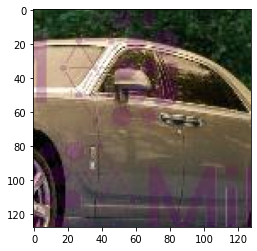

In [101]:
plt.imshow(a[90])

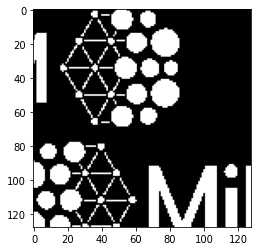

In [102]:
plt.imshow(b[90])

attention mechanism

In [126]:
def filter(inlayer,filter, bn =0):
  a2 = Conv2D(filter,3,activation='relu',strides=2)(inlayer)
  a1 = Activation('sigmoid')(GlobalMaxPool2D()(a2))
  a3 = Multiply()([a1,a2])
  a3 = Conv2D(filter,3,activation = 'relu', padding = 'same')(a3)
  a4 = Add()([a3,a2])
  if bn == 1 :
    a = BatchNormalization()(a4)
    # a = MaxPooling2D()(a)
  else:
    a = a4
  
  return a

In [127]:
def filter1(inlayer,filter):
  a = Conv2DTranspose(filter,3,activation='relu',strides = 2)(inlayer)
  a = BatchNormalization()(a)
  
  return a

Model

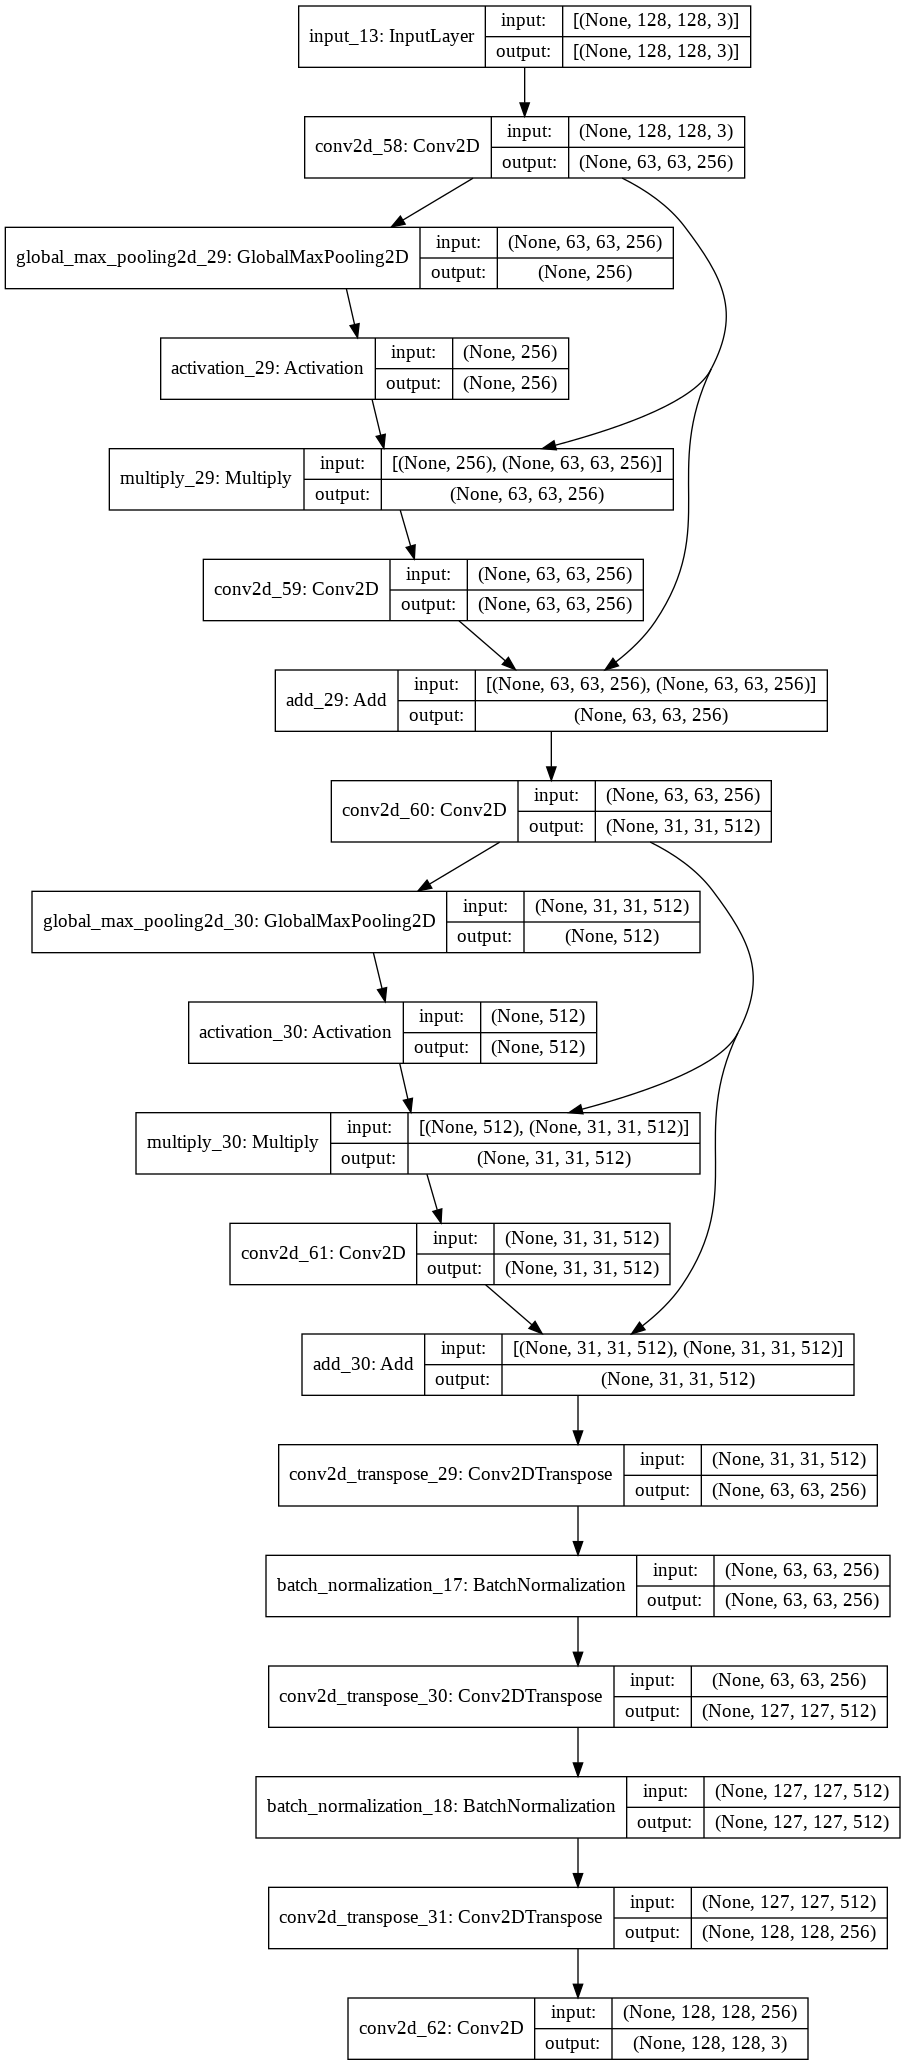

In [150]:
s1 = Input(shape=(128,128,3))
es1 = filter(s1,256)
es1 = filter(es1,512)

es1 = filter1(es1,256)
es1 = filter1(es1,512)
es1 = Conv2DTranspose(256,2,activation='relu')(es1)
es1 = Conv2D(3,3,activation='sigmoid',padding = 'same')(es1)

#es1 = Flatten()(es1)
encs1 = keras.Model((s1), (es1))
keras.utils.plot_model(encs1, "multi_input_and_output_model.png", show_shapes=True)

In [155]:
encs1.compile(optimizer=keras.optimizers.Adam(5e-4), loss= ('binary_crossentropy'), metrics = [iou])

In [163]:
for epoch in range(1000):
  gc.collect()
  i,m  = gensample(50) 
  history = encs1.fit(i,m,batch_size = 32)

  
  # if epoch %99 == 0 :
  #   encs2.save('/content/drive/MyDrive/encs2/encs2.h5')
  # gc.collect()

 6/19 [========>.....................] - ETA: 6s - loss: 0.0254 - iou: 0.8346

KeyboardInterrupt: ignored

save the model

In [170]:
encs1.save('/content/drive/MyDrive/logo.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


test the model

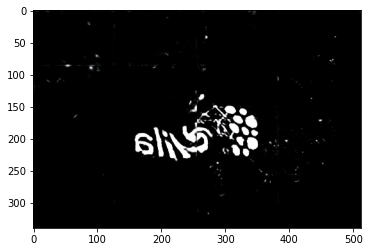

In [164]:
image1 = cv2.imread('/content/drive/MyDrive/mila/train/img/0a9bcd95d9faff39.jpg') #write the path
image1 = resize(np.asarray(image1),(512,512,3))

sed = np.zeros((512,512,3))
sx = []
for i in range(0,511,128):
  for j in range(0,511,128):

    sx.append(image1[i:i+128,j:j+128,:])

sx1 = np.asarray(sx)
pred = encs1.predict(sx1,batch_size = 4)
sed1 = np.zeros((512,512,3))
t = 0
for i in range(0,511,128):
  for j in range(0,511,128):
    sed1[i:i+128,j:j+128,:] = pred[t]
    t+=1

plt.imshow(resize(sed1,(340,512,3)))

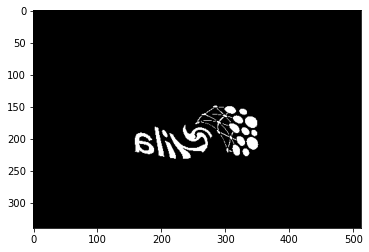

In [158]:
mask = cv2.imread('/content/drive/MyDrive/mila/train/mask/0a9bcd95d9faff39.bmp')
mask = np.asarray(mask)
plt.imshow(mask)

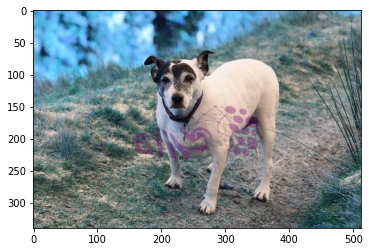

In [167]:
im = cv2.imread('/content/drive/MyDrive/mila/train/img/0a9bcd95d9faff39.jpg')
im = np.asarray(im)
plt.imshow(im)

Done.